### **Import Libraries**

In [451]:
#Import Libraries
import numpy as np
import os
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET

from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import tv_tensors
from torchvision.models.detection.image_list import ImageList
from PIL import Image, ImageDraw
from tqdm import tqdm
from engine import train_one_epoch, evaluate

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")


#Reference for Faster R-CNN Model: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.
#https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=QDFCNe8r_x6B

### **Update Paths to Images and Annotations Folder**

In [6]:
#Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Locations of images and annotations in google drive
images = os.listdir('/content/drive/MyDrive/FaceMask_Dataset/images')
annotations = os.listdir('/content/drive/MyDrive/FaceMask_Dataset/annotations')
root_dir = '/content/drive/MyDrive/FaceMask_Dataset'

#images = list(sorted(os.listdir('/Users/abdulbhutta/Desktop/Deep Learning/Final_Project/FaceMask_Dataset/images')))
#annotations = list(sorted(os.listdir('/Users/abdulbhutta/Desktop/Deep Learning/Final_Project/FaceMask_Dataset/annotations')))
#root_dir = '/Users/abdulbhutta/Desktop/Deep Learning/Final_Project/FaceMask_Dataset'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Pre-Processing Data**

In [11]:
#View the Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
class Mask_Dataset(object):
  def __init__(self, root_dir, transform):
        self.image_dir = os.path.join(root_dir, 'images')
        self.annotations_dir = os.path.join(root_dir, 'annotations')
        self.transform = transform
        self.image_names = os.listdir(self.image_dir)
        self.image_names.sort()

  def __len__(self):
      return len(self.image_names)

  def __getitem__(self, idx):
        #Get the image and annotations path for each image
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        annotations_path = os.path.join(self.annotations_dir, self.image_names[idx].split('.')[0] + '.xml')
        tree = ET.parse(annotations_path) #Parse the xml file
        root = tree.getroot()

        #Get the bounding boxes and labels for each image and append them to the list
        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            if label == 'with_mask':
                labels.append(1)
            elif label == 'without_mask':
                labels.append(2)
            elif label == 'mask_weared_incorrect':
                labels.append(3)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])

        #Tried to get the masks segmentation but it was not working properly
        masks = []
        for obj in root.findall('object'):
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            mask[ymin:ymax, xmin:xmax] = 1
            masks.append(mask)

        #Get the target dictionary for each image
        target = {}
        num_objs = len(boxes)
        boxes = torch.tensor(boxes, dtype=torch.float32) #Convert boxes to tensor
        labels = torch.tensor(labels) #Convert labels to tensor
        target['boxes'] = boxes #Bounding boxes
        target['labels'] = labels #Labels
        target['image_id'] = torch.tensor([idx]) #Image id
        target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) #Area of the bounding box
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64) #No crowd in this dataset
        target["masks"] = torch.as_tensor(masks, dtype=torch.uint8) #Masks

        #Return the image and target dictionary
        return image, target

In [14]:
#Define the transforms to be applied to each image
data_transform = transforms.Compose([transforms.ToTensor()]) #Convert the image to a tensor which have pixel values between 0 and 1

#collate_fn needed to collate the data into batches for training because the images are not all the same size and have different people wearing masks
def collate_fn(batch):
    return tuple(zip(*batch))

In [15]:
#Define the dataset
dataset = Mask_Dataset(root_dir, data_transform)
#test_data = Mask_Dataset('/Users/abdulbhutta/Desktop/Deep Learning/Final_Project/FaceMask_Dataset', data_transform)

#Split the dataset into training and test sets using train_test_split
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size]) #Split the dataset into training and test sets

#Verify the length of the training and test sets
print(len(train_data))
print(len(test_data))

#define training and test data loaders
data_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

#verify test and train data
print(len(data_loader))
print(len(data_loader_test))

810
43
203
22


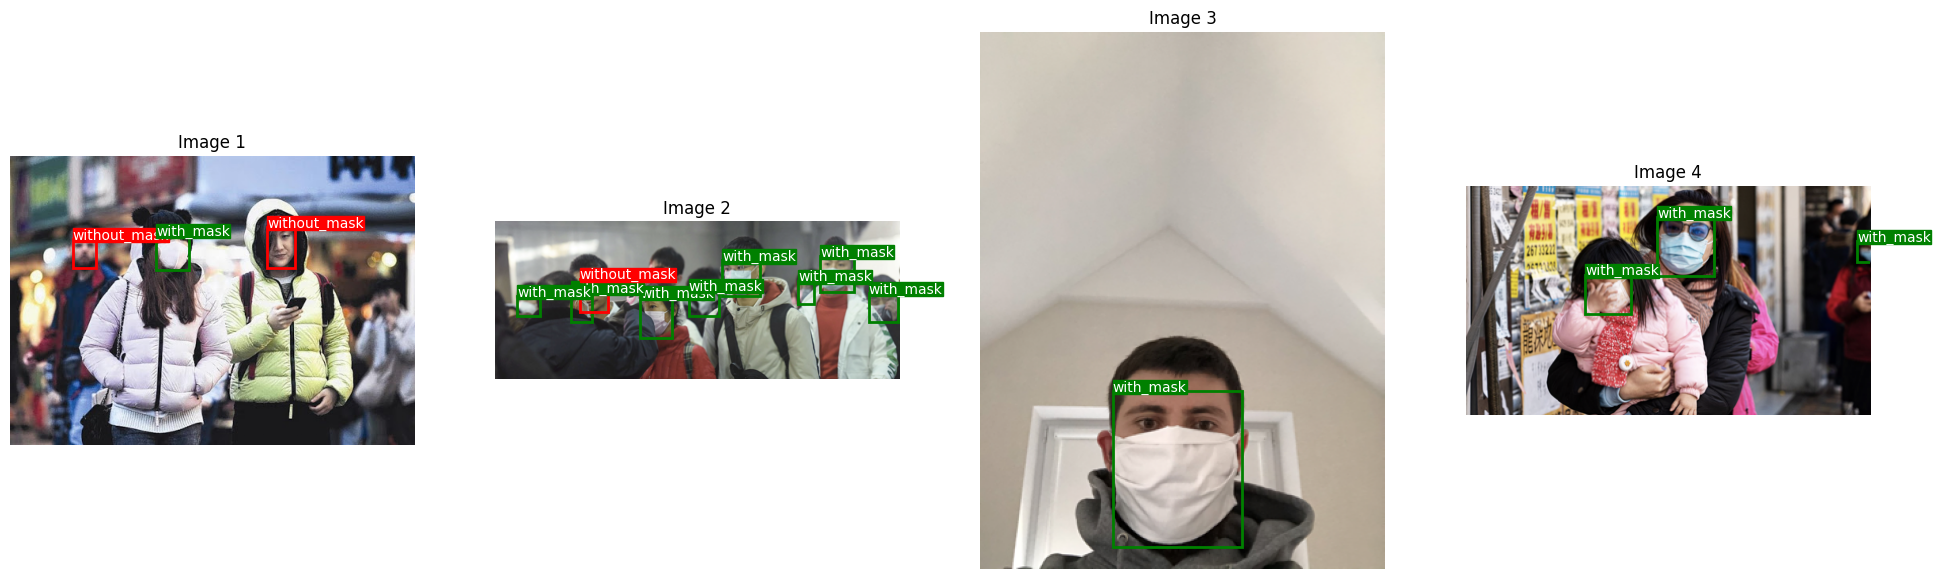

In [95]:
#Create a list of the class names and assign colors to each class for plotting
class_names = ['with_mask', 'without_mask', 'mask worn incorrectly']
colors = ['green', 'red', 'yellow']

#plot the first three images in train dataset with bounding boxes and labels side by side
figure, subplots = plt.subplots(1, 4, figsize=(24, 12))  #figsize = (width, height)

#Plot the first 4 images in the training dataset
for i in range(4):
    image, target = dataset[i]
    image = image.permute(1,2,0)
    image = image.numpy()
    subplots[i].imshow(image)

    #Plot the bounding boxes and labels for each image
    for j in range(len(target['boxes'])):
        xmin = target['boxes'][j][0]
        ymin = target['boxes'][j][1]
        xmax = target['boxes'][j][2]
        ymax = target['boxes'][j][3]
        label = target['labels'][j]
        subplots[i].add_patch(patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=colors[label-1], facecolor='none'), )
        subplots[i].text(xmin, ymin, class_names[label-1], fontsize=10, color='white', bbox={'color': colors[label-1], 'pad': 0})
        subplots[i].axis('off')
        subplots[i].set_title('Image ' + str(i+1))

plt.show()

### **Training Begins**

In [ ]:
#Reference: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=QDFCNe8r_x6B

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [18]:
#Define the device to be used for training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 4 #3 classes + background

# get the model with the custom classes
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
#Parameters to be trained in the model
parameters = [p for p in model.parameters() if p.requires_grad]

#Optimizer = Stochastic Gradient Descent and its parameters
optimizer = torch.optim.SGD(
    parameters,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

#Learning rate scheduler and its parameters
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 50

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/203]  eta: 0:19:52  lr: 0.000030  loss: 1.9528 (1.9528)  loss_classifier: 1.6295 (1.6295)  loss_box_reg: 0.1554 (0.1554)  loss_objectness: 0.1318 (0.1318)  loss_rpn_box_reg: 0.0361 (0.0361)  time: 5.8747  data: 2.3640  max mem: 6126
Epoch: [0]  [ 10/203]  eta: 0:02:57  lr: 0.000277  loss: 1.8007 (1.6997)  loss_classifier: 1.4154 (1.3006)  loss_box_reg: 0.1283 (0.1366)  loss_objectness: 0.2122 (0.2263)  loss_rpn_box_reg: 0.0361 (0.0362)  time: 0.9218  data: 0.2201  max mem: 7278
Epoch: [0]  [ 20/203]  eta: 0:02:08  lr: 0.000524  loss: 1.1738 (1.2457)  loss_classifier: 0.5268 (0.8654)  loss_box_reg: 0.1803 (0.1835)  loss_objectness: 0.1126 (0.1637)  loss_rpn_box_reg: 0.0160 (0.0331)  time: 0.4463  data: 0.0063  max mem: 7985
Epoch: [0]  [ 30/203]  eta: 0:01:47  lr: 0.000772  loss: 0.7647 (1.1398)  loss_classifier: 0.3975 (0.7305)  loss_box_reg: 0.2835 (0.2461)  loss_objectness: 0.0583 (0.1324)  loss_rpn_box_reg: 0.0194 (0.0308)  time: 0.4567  data: 0.0060  max mem: 7985


In [ ]:
# save model after training
torch.save(model.state_dict(), '/content/drive/MyDrive/FaceMask_Dataset/model6.pth')

# load model
model.load_state_dict(torch.load('/content/drive/MyDrive/FaceMask_Dataset/model6.pth'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [19]:
# Load pre-trained ResNet50 and view its architecture
print(model.backbone)

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

### **Save the trained Model**

In [97]:
#Load the model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=4)
model.load_state_dict(torch.load('/content/drive/MyDrive/FaceMask_Dataset/model.pth'))
model.eval()

#Assign number of classes
num_classes = 4 # 3 classes (with_mask, without_mask, mask_weared_incorrect) + 1

#View the size of the test dataset
len_dataloader_test = len(data_loader_test)
print(len_dataloader_test)

# load one image from train dataset and transform it
img = Image.open('/content/drive/MyDrive/FaceMask_Dataset/images/maksssksksss0.png')
img = data_transform(img)
img = img.unsqueeze(0)

#Get the predictions for the image
prediction = model(img)
print(prediction)

22
[{'boxes': tensor([[185.1673, 100.4298, 226.2823, 145.1416],
        [324.3448,  90.8530, 359.5431, 142.2313],
        [ 77.5032, 103.8769, 111.1239, 141.3350],
        [ 77.4094, 104.8710, 110.6761, 140.1225]], grad_fn=<StackBackward0>), 'labels': tensor([1, 2, 2, 3]), 'scores': tensor([0.9986, 0.9854, 0.9649, 0.0838], grad_fn=<IndexBackward0>)}]


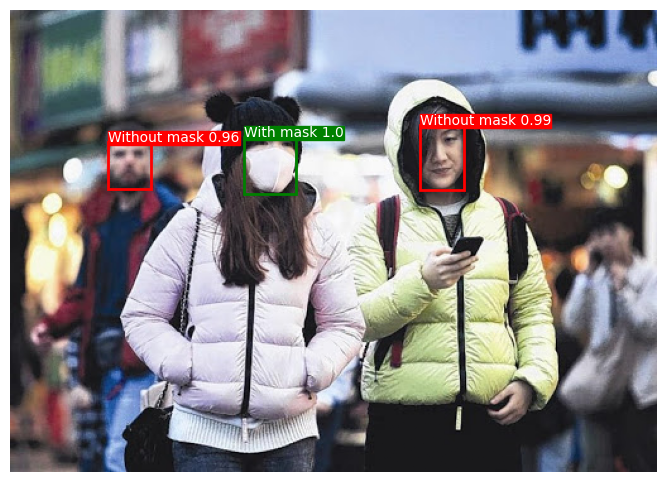

In [110]:
#Plot the image with the bounding boxes and labels
figure, subplots = plt.subplots(1, 1, figsize=(12, 6))
boxes = prediction[0]['boxes'].cpu().detach().numpy()
scores = prediction[0]['scores'].cpu().detach().numpy()
labels = prediction[0]['labels'].cpu().detach().numpy()

#Plot the bounding boxes, labels and scores for each image
for box, score, label in zip(boxes, scores, labels):
  if score > 0.5:
    color = colors[label-1]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
    subplots.add_patch(rect)
    subplots.text(box[0], box[1], class_names[label-1] + ' ' + str(round(score, 2)), fontsize=10, color='white', bbox={'color': color, 'pad': 0})
    subplots.axis('off')

plt.imshow(img[0].permute(1, 2, 0))
plt.show()


### **Testing Model - BackBone Layer**

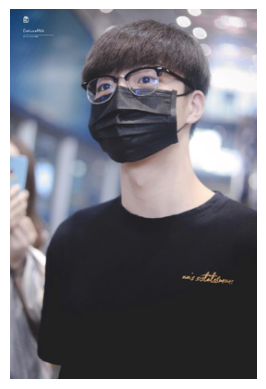

In [694]:
#print out the first image in the test dataset
image, annotations = data_loader_test.dataset[0]
image = image.unsqueeze(0)

#display the image
plt.axis('off')
plt.imshow(image.squeeze(0).permute(1, 2, 0))
plt.show()

In [695]:
#Load the model
num_classes = 4
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=4)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/FaceMask_Dataset/model.pth'))

#Change the device to cuda if available else use cpu
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Test on a single image and display what happens at each stage of the model (backbone, rpn, roi_heads)
image, annotation = data_loader_test.dataset[0]
image = image.to(device)

#backbone
backbone = model.backbone
backbone.eval()
backbone.to(device)
image = backbone(image.unsqueeze(0)) #unsqueeze to add a dimension for batch size of 1

#img is a disctionary and the key is the layer name and the value is the output of that layer
print(image.keys())

odict_keys(['0', '1', '2', '3', 'pool'])


In [117]:
#View the architecture of the backbone model
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=1e-05)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=1e-05)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=1e-05)
        )
      )
      (1): Bottleneck(
        

Total filters in layer 0: 256 



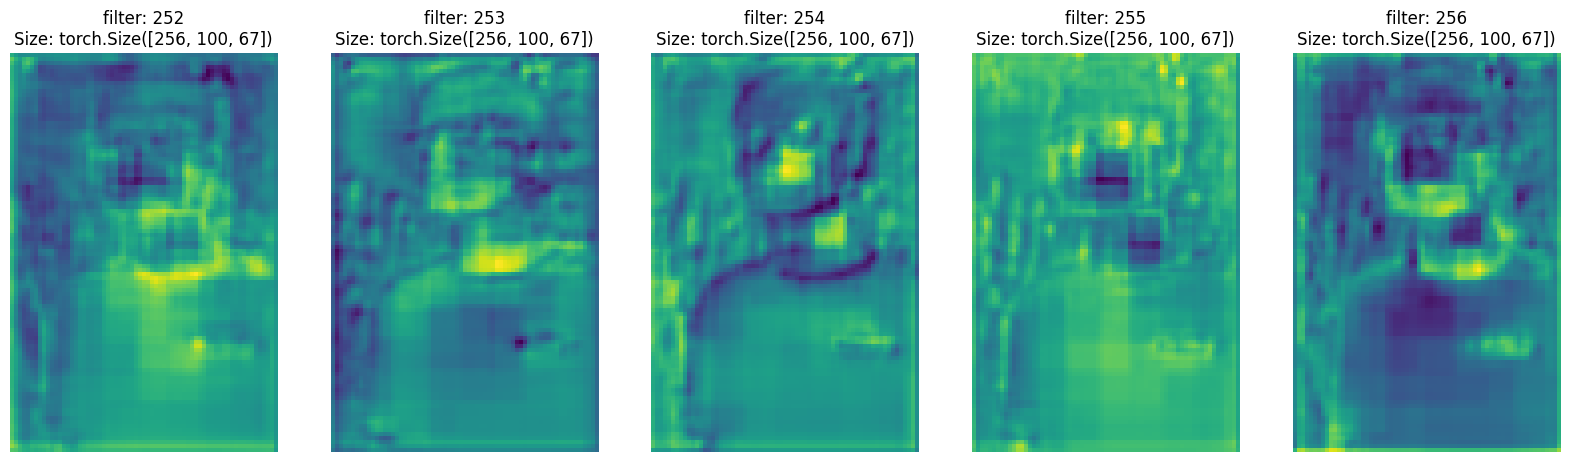

In [696]:
#print out last five images in layer 0
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    axis.imshow(image['0'].detach().cpu().numpy()[0][i+251])
    axis.axis('off')
    axis.set_title('filter: ' + str(i+252) + '\nSize: ' + str(image[str(0)][0].shape))

#Total filters in layer 0
print(f'Total filters in layer 0: {image["0"].shape[1]} \n')

Total filters in layer 1: 256 



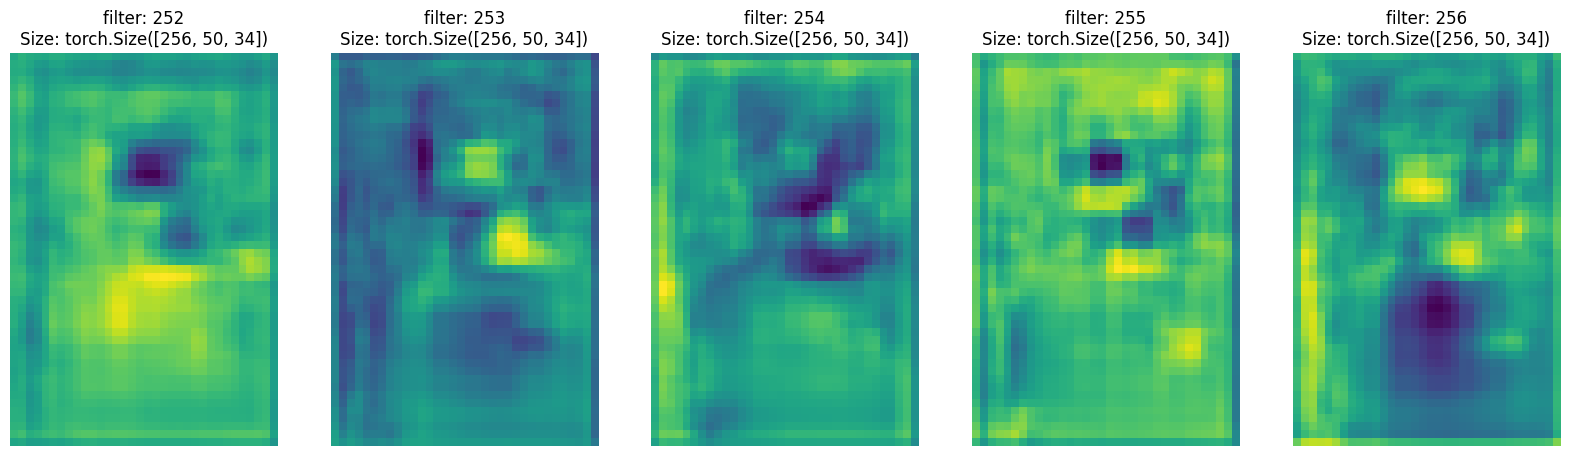

In [697]:
#Dispay the last five images in layer 1
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    axis.imshow(image['1'].detach().cpu().numpy()[0][i+251])
    axis.axis('off')
    #filter number and torch.size[h, w, filters]
    axis.set_title('filter: ' + str(i+252) + '\nSize: ' + str(image[str(1)][0].shape))

#Total filters in layer 1
print(f'Total filters in layer 1: {image["1"].shape[1]} \n')


Total filters in layer 2: 256 



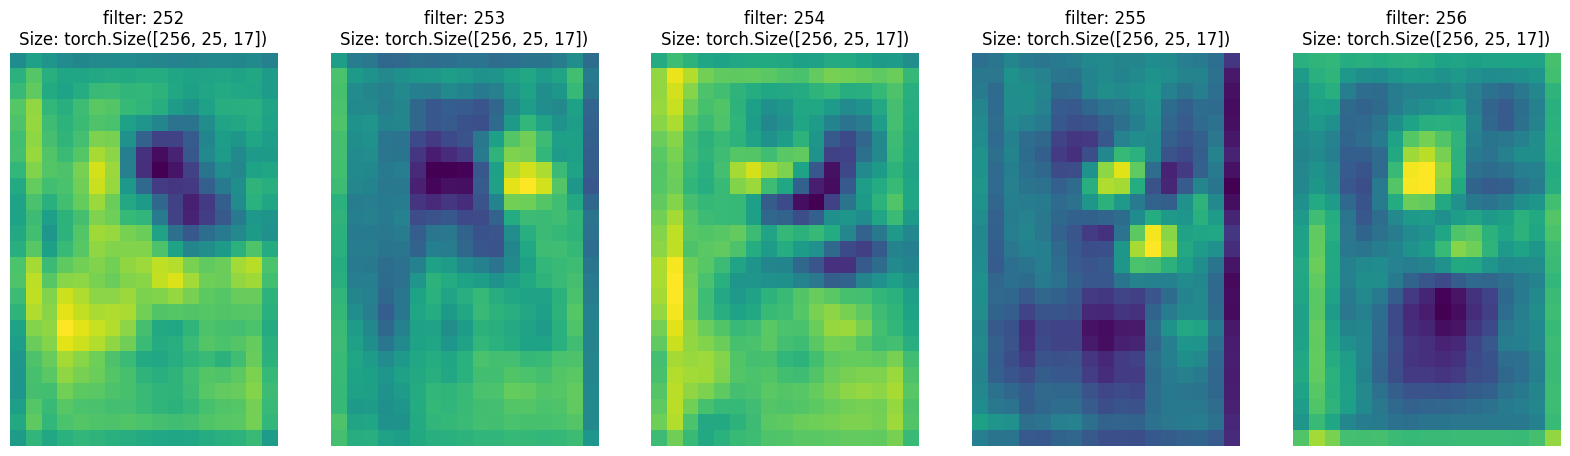

In [698]:
#Display the last five images in layer 2
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    axis.imshow(image['2'].detach().cpu().numpy()[0][i+251])
    axis.axis('off')
    #filter number and torch.size[h, w, filters]
    axis.set_title('filter: ' + str(i+252) + '\nSize: ' + str(image[str(2)][0].shape))

#Total filters in layer 2
print(f'Total filters in layer 2: {image["2"].shape[1]} \n')


Total filters in layer 3: 256 



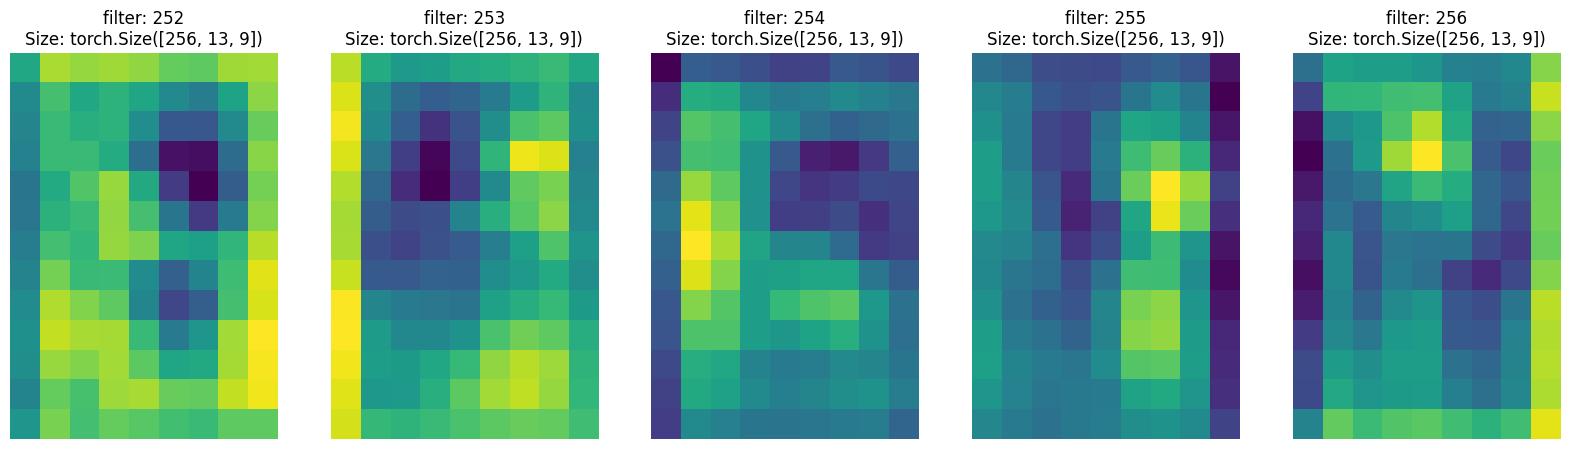

In [699]:
#Display the last five images in layer 3
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    axis.imshow(image['3'].detach().cpu().numpy()[0][i+251])
    axis.axis('off')
    #filter number and torch.size[h, w, filters]
    axis.set_title('filter: ' + str(i+252) + '\nSize: ' + str(image[str(3)][0].shape))

#Total filters in layer 3
print(f'Total filters in layer 3: {image["3"].shape[1]} \n')

Total filters in pool layer: 256 



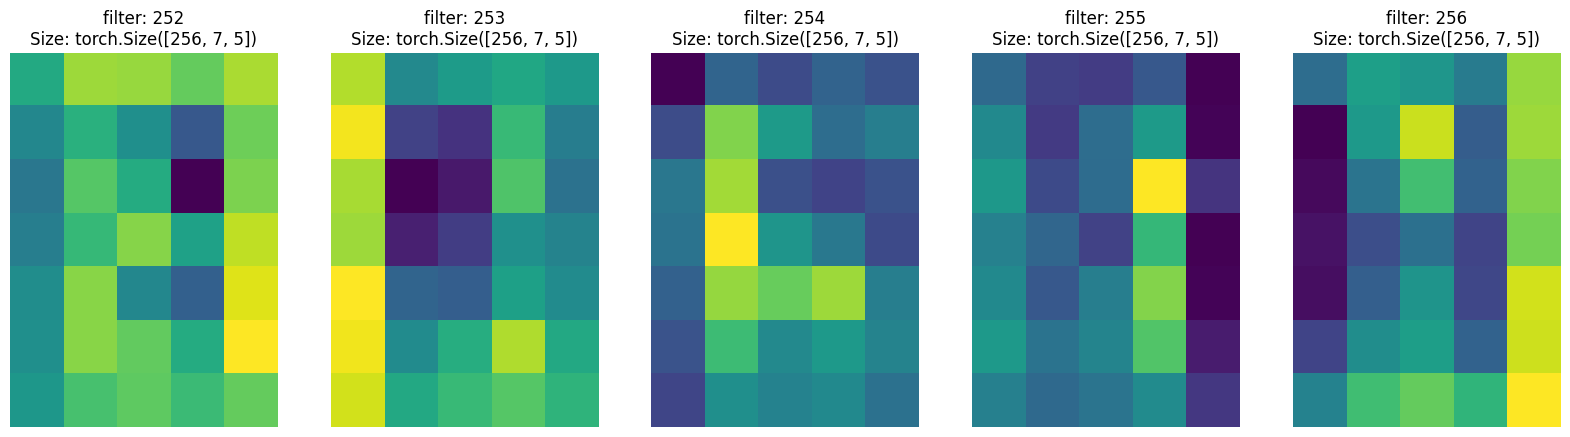

In [700]:
#Display the last five images in pool layer
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    axis.imshow(image['pool'].detach().cpu().numpy()[0][i+251])
    axis.axis('off')
    #filter number and torch.size[h, w, filters]
    axis.set_title('filter: ' + str(i+252) + '\nSize: ' + str(image['pool'][0].shape))

#Total filters in pool layer
print(f'Total filters in pool layer: {image["pool"].shape[1]} \n')

torch.Size([1, 256, 100, 67])
torch.Size([1, 256, 50, 34])
torch.Size([1, 256, 25, 17])
torch.Size([1, 256, 13, 9])
torch.Size([1, 256, 7, 5])




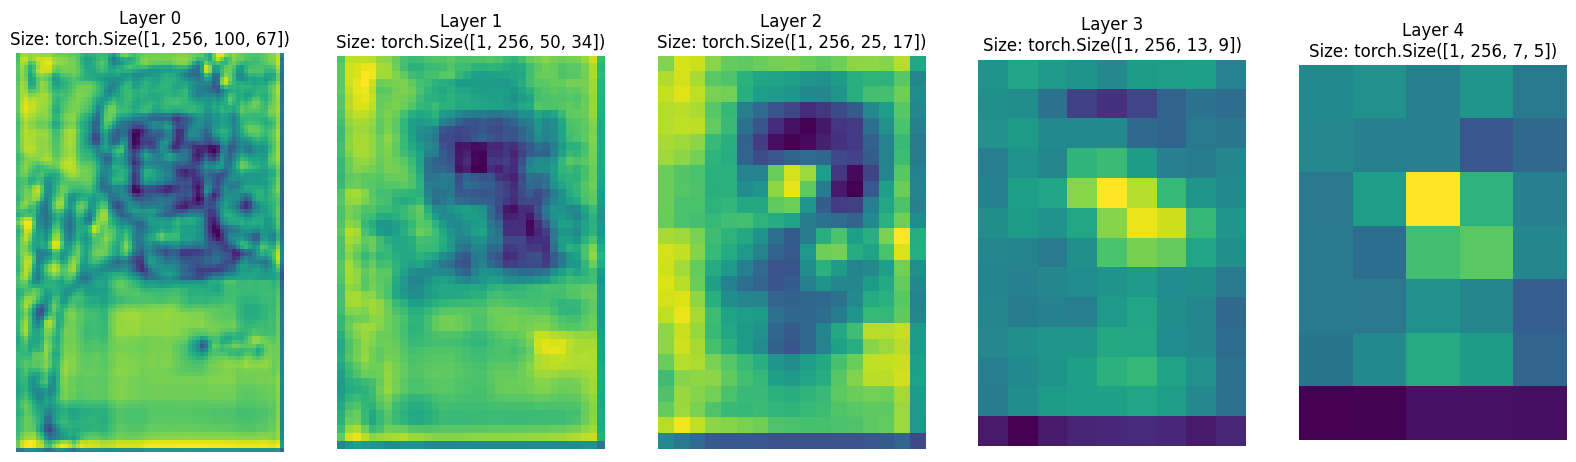

In [701]:
#get the last image in each layer of the backbone that is sent to the next layer of the model
for i in range(0, 5):
    if i == 4:
      print(image['pool'].shape) #torch.Size([1, 256, 67, 100])
    else:
      print(image[str(i)].shape) #torch.Size([1, 256, 67, 100]), 256 is the total number of filters in the layer, 67 is the height of the image, 100 is the width of the image

print("\n")

#display the last image in each layer of the backbone that is sent to the next layer of the model side by side
figure, subplots = plt.subplots(1, 5, figsize=(20, 20))
for i, axis in enumerate(subplots.flat, 0):
    if i == 4:
      axis.imshow(image['pool'].detach().cpu().numpy()[0][0])
      axis.axis('off')
      axis.set_title('pool')
      axis.set_title("Layer " + str(i) + "\nSize: " + str(image['pool'].shape))
    else:
      axis.imshow(image[str(i)].detach().cpu().numpy()[0][0])
      axis.axis('off')
      axis.set_title("Layer " + str(i) + "\nSize: " + str(image[str(i)].shape))

### **Testing Model - RPN/ROI Layer**

In [154]:
#Load the model
num_classes = 4
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, num_classes=4)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/FaceMask_Dataset/model.pth'))

model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [702]:
#Map to CPU
device = torch.device('cpu')
model.to(device)


#Test the model on the first image in the test data
image, target = test_data[0]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([image.to(device)])

print(image)
print(prediction)


#Unnormalize the image
image = (255 * (image - image.min()) / (image.max() - image.min())).numpy().astype(np.uint8)

print(image)

tensor([[[0.1020, 0.1020, 0.0980,  ..., 0.5216, 0.5216, 0.5373],
         [0.0980, 0.0980, 0.0980,  ..., 0.5255, 0.5255, 0.5412],
         [0.0902, 0.0941, 0.0980,  ..., 0.5294, 0.5373, 0.5529],
         ...,
         [0.3765, 0.3725, 0.3843,  ..., 0.1294, 0.1294, 0.1294],
         [0.3529, 0.3529, 0.3686,  ..., 0.1294, 0.1294, 0.1294],
         [0.3412, 0.3451, 0.3647,  ..., 0.1294, 0.1294, 0.1294]],

        [[0.2510, 0.2510, 0.2471,  ..., 0.5020, 0.5020, 0.5137],
         [0.2471, 0.2471, 0.2431,  ..., 0.5020, 0.5020, 0.5216],
         [0.2392, 0.2392, 0.2431,  ..., 0.4980, 0.5020, 0.5216],
         ...,
         [0.3765, 0.3725, 0.3843,  ..., 0.1294, 0.1294, 0.1294],
         [0.3529, 0.3569, 0.3686,  ..., 0.1294, 0.1294, 0.1294],
         [0.3490, 0.3529, 0.3725,  ..., 0.1294, 0.1294, 0.1294]],

        [[0.4392, 0.4392, 0.4353,  ..., 0.5294, 0.5294, 0.5412],
         [0.4353, 0.4353, 0.4314,  ..., 0.5294, 0.5294, 0.5490],
         [0.4275, 0.4275, 0.4314,  ..., 0.5294, 0.5373, 0.

[tensor([[ 72.4190,  48.8537, 192.3146, 170.7480],
        [ 92.0902,  45.9205, 195.1980, 195.8603],
        [ 60.8043,  64.3902, 199.6091, 159.1199],
        ...,
        [164.4814, 398.4309, 181.0538, 400.0000],
        [231.9498, 304.4732, 267.0000, 335.3557],
        [138.2118, 398.9202, 154.7643, 400.0000]])]
Total proposals:  1000


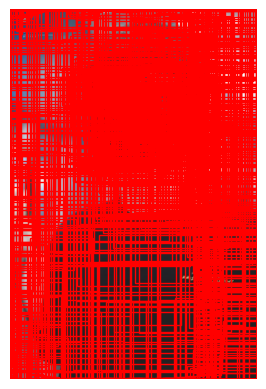

In [703]:
#preprocess the image to be fed into the model
images = ImageList(test_data[0][0].unsqueeze(0), [(test_data[0][0].shape[1], test_data[0][0].shape[2])])
features = model.backbone(images.tensors)
#print(features)

#Get the proposals from the RPN layer and their corresponding scores
proposals, _ = model.rpn(images, features)
print(proposals)

#Total proposals
print("Total proposals: ", len(proposals[0]))

#Covert the image back to PIL format
image = Image.fromarray(images.tensors.squeeze(0).permute(1, 2, 0).mul(255).byte().numpy())

#Display the image outputted by the RPN layer
figure,axis = plt.subplots(1)
axis.imshow(image)
for box in proposals[0]:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    axis.add_patch(rect)
    axis.axis('off')
plt.show()

(-0.5, 266.5, 399.5, -0.5)

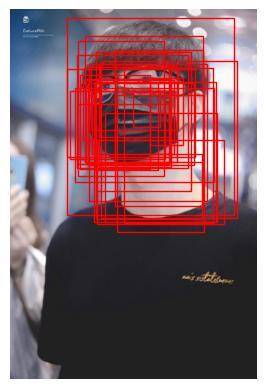

In [709]:
#Get the top 30 proposals from the first test image
proposals, _ = model.rpn(images, features)
proposals = proposals[0][:30] #get the top 20 proposals from the first image
#scores = proposals[:, 4].detach().cpu().numpy()
proposals = proposals[:, :4].detach().cpu().numpy() #get the coordinates of the proposals
#print(proposals)

#Covert the image back to PIL format
image = Image.fromarray(images.tensors.squeeze(0).permute(1, 2, 0).mul(255).byte().numpy())

#Display the image outputted by the RPN layer
figure,ax = plt.subplots(1)
ax.imshow(image)
for box in proposals:
    xmin, ymin, xmax, ymax = box
    rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.axis('off')

In [705]:
image, target = test_data[0]

# put the model in evaluation mode
model.eval()

#Display the final predictions from the model on the first image in the test data
with torch.no_grad():
    prediction = model([image.to(device)])

print(prediction)

[{'boxes': tensor([[ 83.8055,  55.2623, 193.9653, 165.2970]]), 'labels': tensor([1]), 'scores': tensor([0.9977])}]


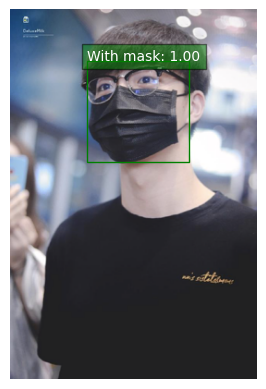

In [706]:
#Save the predictions from the model on the first image in the test data
boxes = prediction[0]['boxes'].cpu().numpy().astype(np.int32)
scores = prediction[0]['scores'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
image = Image.fromarray(images.tensors.squeeze(0).permute(1, 2, 0).mul(255).byte().numpy())

#Display the final predictions from the model on the first image in the test data
figure,axis = plt.subplots(1)
axis.imshow(image)
for box, score, label in zip(boxes, scores, labels):
    if label == 1:
      label = 'With mask'
      color = 'green'
    elif label == 2:
      label = 'Incorrect mask'
      color = 'yellow'
    elif label == 3:
      label = 'Without mask'
      color = 'red'
    xmin, ymin, xmax, ymax = box

    if score > 0.5:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=color,facecolor='none')
      axis.add_patch(rect)
      axis.text(xmin, ymin, f'{label}: {score:.2f}', fontsize=10, color='white', bbox=dict(facecolor=color, alpha=0.5))

plt.axis('off')
plt.show()

### **Testing Model on Test Data**

In [279]:
!pip install utils
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
%cd Tutorial-Book-Utils/
import utils_ObjectDetection as utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0
Receiving objects: 100% (45/45), 11.62 KiB | 264.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.
/content/Tutorial-Book-Utils/Tutorial-Book-Utils


In [683]:
#Define the dataset
dataset = Mask_Dataset(root_dir, data_transform)
#test_data = Mask_Dataset('/Users/abdulbhutta/Desktop/Deep Learning/Final_Project/FaceMask_Dataset', data_transform)

#Split the dataset into training and test sets using train_test_split
train_size = int(0.95 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

print(len(train_data))
print(len(test_data))

#define training and test data loaders
data_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)
data_loader_test = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

#verify test and train data
print(len(data_loader))
print(len(data_loader_test))

810
43
203
43


In [684]:
def get_predictions(model, image, threshold):
    model.eval()
    prediction = model(image)
    for id in range(len(prediction)):
        index_list = []
        for index, score in enumerate(prediction[id]['scores']):
            if score > threshold:
                index_list.append(index)
        prediction[id]['boxes'] = prediction[id]['boxes'][index_list]
        prediction[id]['labels'] = prediction[id]['labels'][index_list]
        prediction[id]['scores'] = prediction[id]['scores'][index_list]
        #prediction[id]['image_id'] = image[0]['image_id']
    return prediction

In [685]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

labels = []
prediction_all = []
annotations_all = []

#tqdm is used to display the progress bar for the for loop
for image, annotations in tqdm(data_loader_test, position = 0, leave = True):
    image = list (img.to(device) for img in image)

    for target in annotations:
        labels += target['labels']

    with torch.no_grad():
        prediction = get_predictions(model, image, 0.5)
        prediction = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in prediction]
        prediction_all.append(prediction)
        annotations_all.append(annotations)

100%|██████████| 43/43 [00:08<00:00,  5.37it/s]


### **Testing Data Metrics**

In [687]:
#Source: https://github.com/Pseudo-Lab/Tutorial-Book-Utils/blob/main/utils_ObjectDetection.py
metrics = []
for batch in range(len(prediction_all)):
    metrics += utils.get_batch_statistics(prediction_all[batch], annotations_all[batch], iou_threshold=0.5)

true_positives, prediction_score, prediction_label = [torch.cat(x, 0) for x in list(zip(*metrics))]  # all the batches get concatenated
precision, recall, AP, f1, ap_class = utils.ap_per_class(true_positives, prediction_score, prediction_label, torch.tensor(labels))
mAP = torch.mean(AP)

print(f'mAP : {mAP}')
print(f'AP : {AP}')
print(f'precision : {precision}')
print(f'recall : {recall}')
print(f'f1 : {f1}')

mAP : 0.7332182405021991
AP : tensor([0.9997, 1.0000, 0.2000], dtype=torch.float64)
precision : tensor([0.9704, 0.9394, 0.5000])
recall : tensor([1.0000, 1.0000, 0.2000])
f1 : tensor([0.9850, 0.9687, 0.2857])


In [733]:
#Calculate how many images were correctly classified and how many were incorrectly classified
correct = 0
incorrect = 0
incorrect_images = []
correct_images = []
correct_with_mask = 0
correct_without_mask = 0
correct_incorrect_mask = 0
incorrect_with_mask = 0
incorrect_without_mask = 0
incorrect_incorrect_mask = 0

for i in range(len(prediction_all)):
    #if the length of the prediction and annotation list is the same then the image was correctly classified
    if len(prediction_all[i][0]['labels'].cpu()) == len(annotations_all[i][0]['labels'].cpu()):
        correct += 1
        if len(prediction_all[i][0]['labels'].cpu()) == 1:
            #get the number of images that were correctly classified with mask, without mask and with incorrect mask within each prediction and annotation list
            correct_with_mask = correct_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            correct_without_mask = correct_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            correct_incorrect_mask = correct_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])
        elif len(prediction_all[i][0]['labels'].cpu()) == 2:
            correct_with_mask = correct_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            correct_without_mask = correct_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            correct_incorrect_mask = correct_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])
        elif len(prediction_all[i][0]['labels'].cpu()) == 3:
            correct_with_mask = correct_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            correct_without_mask = correct_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            correct_incorrect_mask = correct_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])
        correct_images.append([i, prediction_all[i], annotations_all[i]])

    #else the image was incorrectly classified
    else:
        incorrect += 1
        #get the number of images that were incorrectly classified with mask, without mask and with incorrect mask within each prediction and annotation list
        if len(prediction_all[i][0]['labels'].cpu()) == 1:
            incorrect_with_mask = incorrect_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            incorrect_without_mask = incorrect_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            incorrect_incorrect_mask = incorrect_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])
        elif len(prediction_all[i][0]['labels'].cpu()) == 2:
            incorrect_with_mask = incorrect_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            incorrect_without_mask = incorrect_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            incorrect_incorrect_mask = incorrect_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])
        elif len(prediction_all[i][0]['labels'].cpu()) == 3:
            incorrect_with_mask = incorrect_with_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 1])
            incorrect_without_mask = incorrect_without_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 2])
            incorrect_incorrect_mask = incorrect_incorrect_mask + len([x for x in prediction_all[i][0]['labels'].cpu() if x == 3])

        #print(f'Image {i} was incorrectly classified')
        #print (f'Image index in Test: {i}')
        #print (f'Expected: {annotations_all[i][0]["labels"]}')
        #print (f'Predicted: {prediction_all[i][0]["labels"]}')
        incorrect_images.append([i, prediction_all[i], annotations_all[i]])

#Print out the results
print(f'Correctly classified images: {correct}')
print(f'Incorrectly classified images: {incorrect}')
print(f'Accuracy: {correct/len(prediction_all)}')
print(f'Correctly classified images with mask: {correct_with_mask}')
print(f'Correctly classified images without mask: {correct_without_mask}')
print(f'Correctly classified images with incorrect mask: {correct_incorrect_mask}')
print(f'Incorrectly classified images with mask: {incorrect_with_mask}')
print(f'Incorrectly classified images without mask: {incorrect_without_mask}')
print(f'Incorrectly classified images with incorrect mask: {incorrect_incorrect_mask}')

Image 3 was incorrectly classified
Image index in Test: 3
Expected: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3, 1, 1, 2, 2, 1])
Predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2])
Image 8 was incorrectly classified
Image index in Test: 8
Expected: tensor([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Predicted: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2])
Image 22 was incorrectly classified
Image index in Test: 22
Expected: tensor([3])
Predicted: tensor([1, 3])
Image 26 was incorrectly classified
Image index in Test: 26
Expected: tensor([1, 1, 3, 1, 1, 1])
Predicted: tensor([1, 1, 1, 1, 1, 1, 3])
Image 32 was incorrectly classified
Image index in Test: 32
Expected: tensor([1])
Predicted: tensor([1, 1])
Image 33 was incorrectly classified
Image index in Test: 33
Expected: tensor([1, 1, 1, 1])
Predicted: tensor([1, 1, 1, 1, 2])
Correctly classified images: 37
Incorrectly classified images: 6
Accuracy: 0.8604651162790697
Correctly classified images with mask: 30
C

In [689]:
#print(correct_images[0])

In [690]:
#(test_data[0])

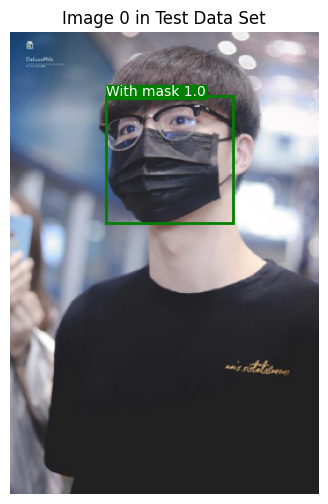

In [691]:
#plot test data [8] with its predictions
image, annotations = test_data[0]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    prediction = get_predictions(model, image, 0.5)

#plot the image with the bounding boxes and labels
figure, subplots = plt.subplots(1, 1, figsize=(12, 6))
boxes = prediction[0]['boxes'].cpu().detach().numpy().astype(np.int32)
scores = prediction[0]['scores'].cpu().detach().numpy()
labels = prediction[0]['labels'].cpu().detach().numpy()

#Plot the bounding boxes, labels and scores for each image
for box, score, label in zip(boxes, scores, labels):
  if score > 0.5:
    color = colors[label-1]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
    subplots.add_patch(rect)
    subplots.text(box[0], box[1], class_names[label-1] + ' ' + str(round(score, 2)), fontsize=10, color='white', bbox={'color': color, 'pad': 0})
    subplots.axis('off')
    subplots.set_title('Image 0 in Test Data Set')

plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.show()

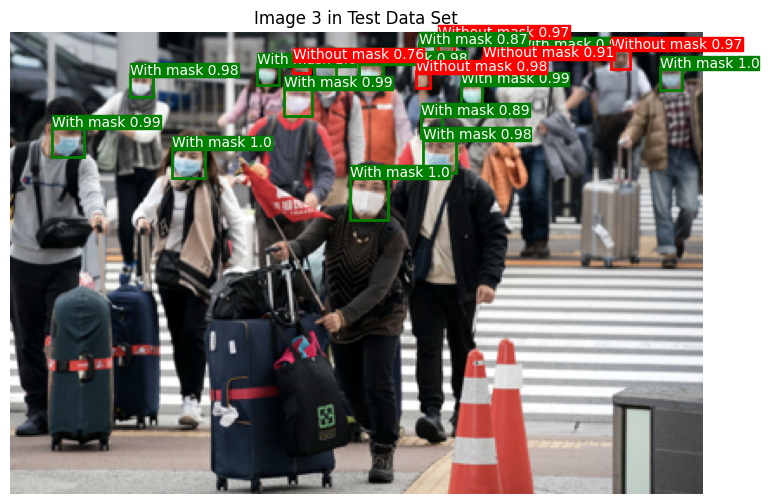

In [692]:
#plot test data [3] with its predictions
image, annotations = test_data[3]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    prediction = get_predictions(model, image, 0.5)

#plot the image with the bounding boxes and labels
figure, subplots = plt.subplots(1, 1, figsize=(12, 6))
boxes = prediction[0]['boxes'].cpu().detach().numpy().astype(np.int32)
scores = prediction[0]['scores'].cpu().detach().numpy()
labels = prediction[0]['labels'].cpu().detach().numpy()

#Plot the bounding boxes, labels and scores for each image
for box, score, label in zip(boxes, scores, labels):
  if score > 0.5:
    color = colors[label-1]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
    subplots.add_patch(rect)
    subplots.text(box[0], box[1], class_names[label-1] + ' ' + str(round(score, 2)), fontsize=10, color='white', bbox={'color': color, 'pad': 0})
    subplots.axis('off')
    subplots.set_title('Image 3 in Test Data Set')

plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.show()

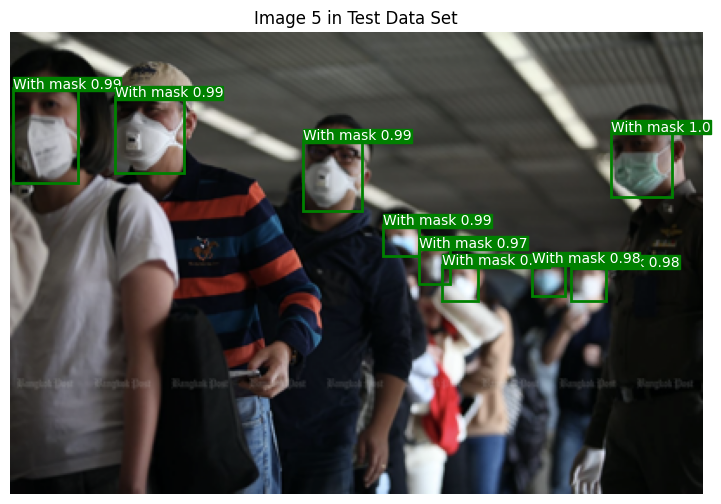

In [707]:
#Plot the test_data[5] and its predictions
image, annotations = test_data[5]
image = image.unsqueeze(0)
image = image.to(device)
with torch.no_grad():
    prediction = get_predictions(model, image, 0.5)

#plot the image with the bounding boxes and labels
figure, subplots = plt.subplots(1, 1, figsize=(12, 6))
boxes = prediction[0]['boxes'].cpu().detach().numpy().astype(np.int32)
scores = prediction[0]['scores'].cpu().detach().numpy()
labels = prediction[0]['labels'].cpu().detach().numpy()

#Plot the bounding boxes, labels and scores for each image
for box, score, label in zip(boxes, scores, labels):
  if score > 0.5:
    color = colors[label-1]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor=color, facecolor='none')
    subplots.add_patch(rect)
    subplots.text(box[0], box[1], class_names[label-1] + ' ' + str(round(score, 2)), fontsize=10, color='white', bbox={'color': color, 'pad': 0})
    subplots.axis('off')
    subplots.set_title('Image 5 in Test Data Set')

plt.imshow(image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.show()